# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn

rn.seed(30)
import tensorflow as tf

tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32  #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
def generator(source_path,
              folder_list,
              batch_size,
              image_shape=(160, 160),
              num_images=20,
              augment=False):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(6, 29, num_images)).astype(
        int)  # 29 since indexing starts from '0'
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size
        for batch in range(
                num_batches):  # we iterate over the number of batches
            batch_data = np.zeros(
                (batch_size, len(img_idx), image_shape[0], image_shape[1], 3)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((
                batch_size,
                5))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(source_path + '/' +
                                  t[folder +
                                    (batch * batch_size)].split(';')[0]
                                  )  # read all the images in the folder
                for idx, item in enumerate(
                        img_idx
                ):  #  Iterate iver the frames/images of a folder to read them in
                    image = imread(
                        source_path + '/' +
                        t[folder +
                          (batch * batch_size)].strip().split(';')[0] + '/' +
                        imgs[item]).astype(np.float32)
                    if (augment):
                        shifted = cv2.warpAffine(
                            image,
                            np.float32([[[1, 0,
                                          np.random.randint(-30, 30)],
                                         [0, 1,
                                          np.random.randint(-30, 30)]]]),
                            (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)

                        cropped = shifted[x0:x1, y0:y1, :]
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = image = imresize(
                            image[:, 20:140, :],
                            (image_shape[0], image_shape[1], 3)).astype(
                                np.float32)
                    else:
                        image = imresize(image, image_shape).astype(np.float32)

                    batch_data[folder, idx, :, :,
                               0] = (image[:, :, 0] -
                                     np.percentile(image[:, :, 0], 95)) / (
                                         np.percentile(image[:, :, 0], 95) -
                                         np.percentile(image[:, :, 0], 5)
                                     )  #normalise and feed in the image
                    batch_data[folder, idx, :, :,
                               1] = (image[:, :, 1] -
                                     np.percentile(image[:, :, 1], 95)) / (
                                         np.percentile(image[:, :, 1], 95) -
                                         np.percentile(image[:, :, 1], 5)
                                     )  #normalise and feed in the image
                    batch_data[folder, idx, :, :,
                               2] = (image[:, :, 2] -
                                     np.percentile(image[:, :, 2], 95)) / (
                                         np.percentile(image[:, :, 2], 95) -
                                         np.percentile(image[:, :, 2], 5)
                                     )  #normalise and feed in the image

                batch_labels[folder,
                             int(t[folder +
                                   (batch *
                                    batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros(
                (len(t) % batch_size, len(img_idx), image_shape[0],
                 image_shape[1], 3)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((
                len(t) % batch_size,
                5))  # batch_labels is the one hot representation of the output
            for folder in range(len(t) %
                                batch_size):  # iterate over the batch_size
                imgs = os.listdir(source_path + '/' +
                                  t[folder +
                                    (num_batches * batch_size)].split(';')[0]
                                  )  # read all the images in the folder
                for idx, item in enumerate(
                        img_idx
                ):  #  Iterate iver the frames/images of a folder to read them in
                    image = imread(
                        source_path + '/' +
                        t[folder +
                          (num_batches * batch_size)].strip().split(';')[0] +
                        '/' + imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = image = imresize(
                            image[:, 20:140, :],
                            (image_shape[0], image_shape[1], 3)).astype(
                                np.float32)
                    else:
                        image = imresize(image, image_shape).astype(np.float32)

                    batch_data[folder, idx, :, :,
                               0] = (image[:, :, 0] -
                                     np.percentile(image[:, :, 0], 95)) / (
                                         np.percentile(image[:, :, 0], 95) -
                                         np.percentile(image[:, :, 0], 5)
                                     )  #normalise and feed in the image
                    batch_data[folder, idx, :, :,
                               1] = (image[:, :, 1] -
                                     np.percentile(image[:, :, 1], 95)) / (
                                         np.percentile(image[:, :, 1], 95) -
                                         np.percentile(image[:, :, 1], 5)
                                     )  #normalise and feed in the image
                    batch_data[folder, idx, :, :,
                               2] = (image[:, :, 2] -
                                     np.percentile(image[:, :, 2], 95)) / (
                                         np.percentile(image[:, :, 2], 95) -
                                         np.percentile(image[:, :, 2], 5)
                                     )  #normalise and feed in the image

                batch_labels[folder,
                             int(t[folder +
                                   (num_batches *
                                    batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  #you yield the batch_data and the batch_labels, remember what does yield do

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10  # choose the number of epochs
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model

num_images = 20
image_shape = (120, 120)
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [8]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 20, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 10, 60, 60, 16)    0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 9, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 9, 59, 59, 32)     128       
_________________________________________________________________
MaxPooling3D_2 (MaxPooling3D (None, 4, 29, 29, 32)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size, image_shape)
val_generator = generator(val_path, val_doc, batch_size, image_shape)

### Training the model on small amount of data to check for errors.

## Ablation Tests

In [10]:
def ablation(num_folders,
             train_or_val='train',
             image_shape=(160, 160),
             num_images=20,
             augment=False):
    if train_or_val.lower() == 'train':
        file = 'Project_data/train.csv'
        path = train_path
    else:
        file = 'Project_data/val.csv'
        path = val_path

    print('Total folders:', num_folders * 5)

    df = pd.read_csv(file, sep=';', header=None)

    df.columns = ['FileName', 'Gesture', 'GestureIndex']
    while True:
        df = df.groupby(
            'GestureIndex',
            group_keys=False).apply(lambda x: x.sample(num_folders))

        img_idx = np.round(np.linspace(6, 29, num_images)).astype(
            int)  # 29 since indexing starts from '0'

        for batch in range(
                num_folders):  # we iterate over the number of batches
            batch_data = np.zeros(
                (num_folders * 5, len(img_idx), image_shape[0], image_shape[1],
                 3)
            )  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((
                num_folders * 5,
                5))  # batch_labels is the one hot representation of the output

            for i, j in df.iterrows():
                imgs = os.listdir(
                    path + '/' +
                    j['FileName'])  # read all the images in the folder

                for idx, item in enumerate(
                        img_idx
                ):  #  Iterate iver the frames/images of a folder to read them in
                    image = imread(path + '/' + j['FileName'] + '/' +
                                   imgs[item]).astype(np.float32)

                    if (augment):
                        shifted = cv2.warpAffine(
                            image,
                            np.float32([[1, 0,
                                         np.random.randint(-30, 30)],
                                        [0, 1,
                                         np.random.randint(-30, 30)]]),
                            (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)

                        cropped = shifted[x0:x1, y0:y1, :]

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = image = imresize(
                            image[:, 20:140, :],
                            (image_shape[0], image_shape[1], 3)).astype(
                                np.float32)
                    else:
                        image = imresize(
                            image, (image_shape[0], image_shape[1], 3)).astype(
                                np.float32)

                    batch_data[num_folders, idx, :, :,
                               0] = (image[:, :, 0] -
                                     np.percentile(image[:, :, 0], 95)) / (
                                         np.percentile(image[:, :, 0], 95) -
                                         np.percentile(image[:, :, 0], 5)
                                     )  #normalise and feed in the image
                    batch_data[num_folders, idx, :, :,
                               1] = (image[:, :, 1] -
                                     np.percentile(image[:, :, 1], 95)) / (
                                         np.percentile(image[:, :, 1], 95) -
                                         np.percentile(image[:, :, 1], 5)
                                     )  #normalise and feed in the image
                    batch_data[num_folders, idx, :, :,
                               2] = (image[:, :, 2] -
                                     np.percentile(image[:, :, 2], 95)) / (
                                         np.percentile(image[:, :, 2], 95) -
                                         np.percentile(image[:, :, 2], 5)
                                     )  #normalise and feed in the image

                batch_labels[num_folders, j['GestureIndex']] = 1
            yield batch_data, batch_labels  #you yield the batch_data and the batch_labels, remember what does yield do

In [11]:
images = 2  # Number of images required per class

train_ablation_generator = ablation(images,
                                    image_shape=image_shape,
                                    augment=False)
validation_ablation_generator = ablation(images,
                                         train_or_val='val',
                                         image_shape=image_shape)

# Running ablation test to check if the model is doesn't return any errors
history = model.fit(train_ablation_generator,
                    batch_size=2,
                    epochs=num_epochs,
                    steps_per_epoch=5,
                    validation_data=validation_ablation_generator,
                    validation_steps=2,
                    verbose=1,
                    class_weight=None,
                    workers=1)

Total folders: 10
Epoch 1/10
5/5 [==============================] - 8s 2s/step - loss: 1.7172 - categorical_accuracy: 0.2000 - val_loss: 0.9285 - val_categorical_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 2.5506 - categorical_accuracy: 0.2200 - val_loss: 0.8635 - val_categorical_accuracy: 0.1000
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 1.9807 - categorical_accuracy: 0.2200 - val_loss: 0.9033 - val_categorical_accuracy: 0.1000
Epoch 4/10
5/5 [==============================] - 8s 2s/step - loss: 2.4126 - categorical_accuracy: 0.2200 - val_loss: 0.9563 - val_categorical_accuracy: 0.1000
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 2.0760 - categorical_accuracy: 0.1800 - val_loss: 0.9631 - val_categorical_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 2.3035 - categorical_accuracy: 0.2600 - val_loss: 0.9561 - val_categorical_accuracy: 0.0000e+00
Epoch 7/

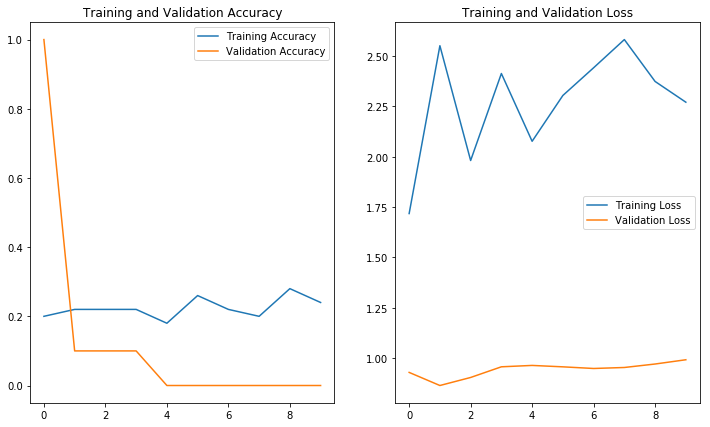

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

## Observations:
The model is running successfully without any errors. 
Since the number of samples selected is less the model is not producing the desired results and is highly unstable too. Its overfitting. 
## Let us run the model on the entire train data in different experiments to select the best parameters.

In [13]:
if not os.path.exists('model'):
    os.mkdir('model')

model_name = 'model' + '_' + str(curr_dt_time).replace(' ', '').replace(
    ':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

LR = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.35,
                       patience=2,
                       verbose=1,
                       mode='min',
                       min_lr=0.00001)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

W0713 07:40:24.765271 140285371483968 callbacks.py:1071] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Experiment 1:
Image size= (120,120) <br>
Epochs =10<br>
Batch size= 32<br>
Number of images =20<br>
Learning Rate = 0.001

In [15]:
history_0 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.9578 - categorical_accuracy: 0.3469Source path =  Project_data/val ; batch size = 32

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-1.95777-0.34691-2.03428-0.14000.h5
21/21 [==============================] - 76s 4s/step - loss: 1.9578 - categorical_accuracy: 0.3469 - val_loss: 2.0343 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.1940 - categorical_accuracy: 0.5716
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.19396-0.57164-2.46320-0.14000.h5
21/21 [==============================] - 76s 4s/step - loss: 1.1940 - categorical_accuracy: 0.5716 - val_loss: 2.4632 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.7632 - categorical_accuracy: 0.7195
Epoch 00003: saving model to mod

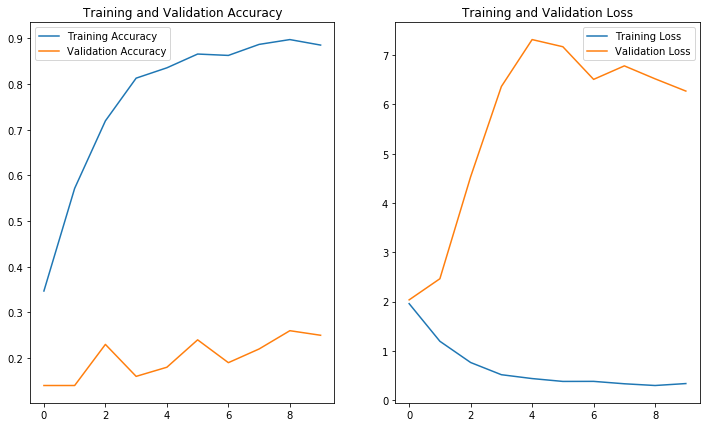

In [16]:
acc = history_0.history['categorical_accuracy']
val_acc = history_0.history['val_categorical_accuracy']

loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
The training data is giving an accuracy of about 89% for 10 epochs 
However the validation accuracy is very low which indicates the model is overfitting.
Let us try adding dropouts to rectify that.

## Experiment 2:

Image size= (120,120) <br>
Epochs =10<br>
Batch size= 32<br>
Number of images =20<br>
Dropouts = "Yes"<br>
Learning Rate = 0.001

In [17]:
print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  32
Image Size:  (120, 120)
Number of images from each folder:  20


In [18]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [19]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 20, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 10, 60, 60, 16)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 60, 60, 16)    0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 9, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 9, 59, 59, 32)    

In [20]:
history_1 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 2.1818 - categorical_accuracy: 0.2986
Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-2.18183-0.29864-5.67775-0.19000.h5
21/21 [==============================] - 77s 4s/step - loss: 2.1818 - categorical_accuracy: 0.2986 - val_loss: 5.6778 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.5504 - categorical_accuracy: 0.4585
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.55042-0.45852-15.09731-0.16000.h5
21/21 [==============================] - 72s 3s/step - loss: 1.5504 - categorical_accuracy: 0.4585 - val_loss: 15.0973 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.1817 - categorical_accuracy: 0.5747
Epoch 00003: saving model to model_2021-07-1307_38_51.238417/model-00003-1.18171-0.57466-21.83317-0.16000.h5

Epoch 00003: ReduceLRO

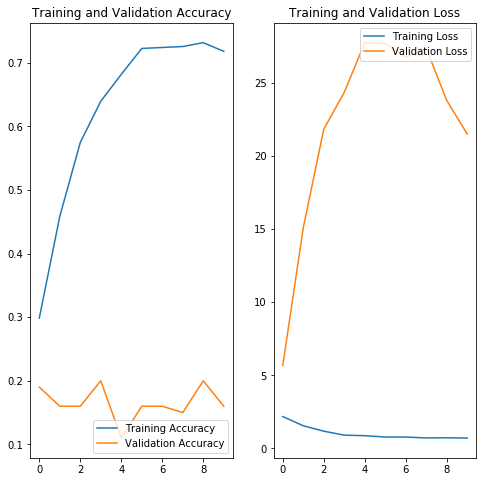

In [21]:
acc = history_1.history['categorical_accuracy']
val_acc = history_1.history['val_categorical_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

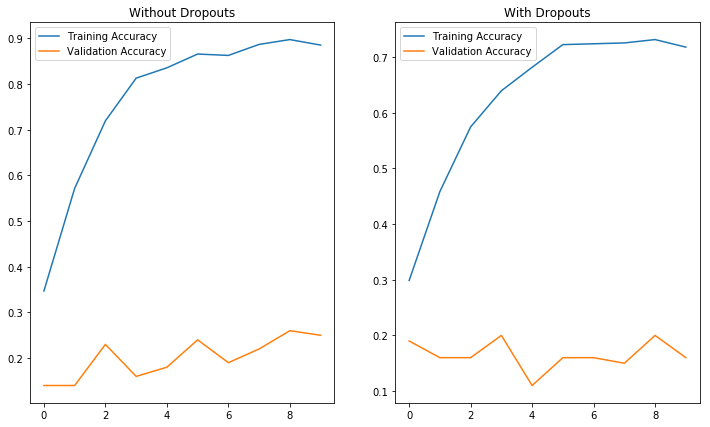

In [22]:
acc_0 = history_0.history['categorical_accuracy']
val_acc_0 = history_0.history['val_categorical_accuracy']

acc_1 = history_1.history['categorical_accuracy']
val_acc_1 = history_1.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_0, label='Training Accuracy')
plt.plot(epochs_range, val_acc_0, label='Validation Accuracy')
plt.legend(loc='best')

plt.title('Without Dropouts')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('With Dropouts')

plt.legend(loc='upper left')
plt.show()

### Observation:
The model is still overfitting, let us experiment on different other parameters to rectify the same.

## Experiment 3: 

Image size= (120,120) <br>
Epochs =10<br>
Batch size= 40<br>
Number of images =20<br>
Cropping of Images = 'False'<br>
Dropouts = "Yes"<br>
Learning Rate = 0.001

In [23]:
batch_size = 40

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (120, 120)
Number of images from each folder:  20


In [24]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [25]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 20, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 20, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 10, 60, 60, 16)    0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 60, 60, 16)    0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 9, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 9, 59, 59, 32)    

In [26]:
train_generator = generator(train_path, train_doc, batch_size, image_shape)
val_generator = generator(val_path, val_doc, batch_size, image_shape)

In [27]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [28]:
history_2 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 2.1226 - categorical_accuracy: 0.3017Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-2.12261-0.30166-1.69437-0.22000.h5
17/17 [==============================] - 75s 4s/step - loss: 2.1226 - categorical_accuracy: 0.3017 - val_loss: 1.6944 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.5742 - categorical_accuracy: 0.4374
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.57416-0.43741-4.15817-0.22000.h5
17/17 [==============================] - 76s 4s/step - loss: 1.5742 - categorical_accuracy: 0.4374 - val_loss: 4.1582 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 1.2047 - categorical_accuracy: 0.5520
Epoch 00003: saving model to mod

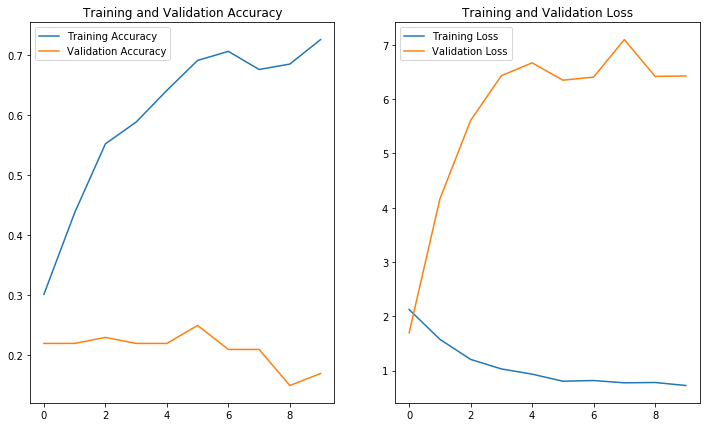

In [29]:
acc = history_2.history['categorical_accuracy']
val_acc = history_2.history['val_categorical_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

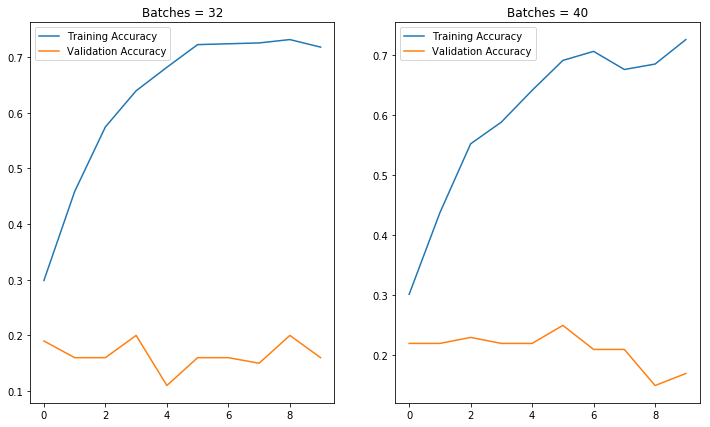

In [30]:
acc_1 = history_1.history['categorical_accuracy']
val_acc_1 = history_1.history['val_categorical_accuracy']

acc_2 = history_2.history['categorical_accuracy']
val_acc_2 = history_2.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Batches = 32')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Batches = 40')

plt.show()

### Observation:
Increasing batch size to 40 improves the model training performance.

## Experiment 4:
Image size= (120,120) <br>
Epochs =10<br>
Batch size= 40<br>
Number of images =12<br>
Dropouts = "Yes"<br>
Learning Rate = 0.001

In [31]:
num_images = 12

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (120, 120)
Number of images from each folder:  12


In [32]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [33]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 12, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 12, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 6, 60, 60, 16)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 60, 60, 16)     0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 6, 60, 60, 32)     4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 5, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 5, 59, 59, 32)    

In [34]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [35]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [36]:
history_3 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 2.1988 - categorical_accuracy: 0.2986Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-2.19883-0.29864-1.84906-0.16000.h5
17/17 [==============================] - 46s 3s/step - loss: 2.1988 - categorical_accuracy: 0.2986 - val_loss: 1.8491 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.6238 - categorical_accuracy: 0.4525
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.62376-0.45249-2.02897-0.14000.h5
17/17 [==============================] - 46s 3s/step - loss: 1.6238 - categorical_accuracy: 0.4525 - val_loss: 2.0290 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 1.3255 - categorical_accuracy: 0.5113
Epoch 00003: saving model to mod

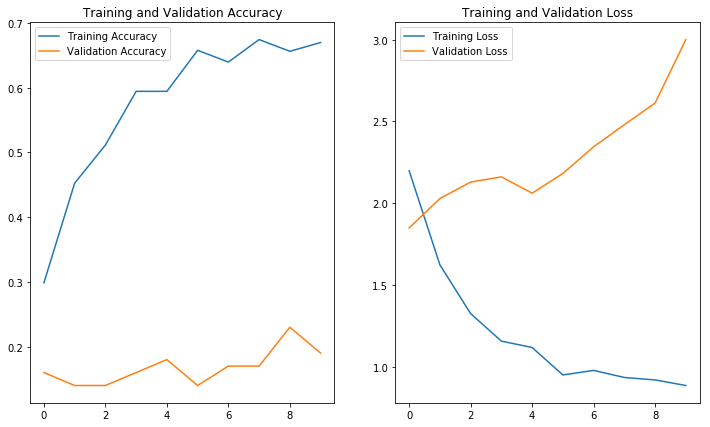

In [37]:
acc = history_3.history['categorical_accuracy']
val_acc = history_3.history['val_categorical_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

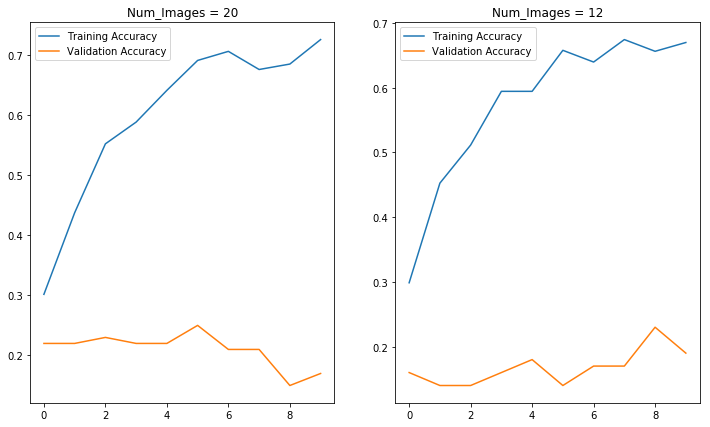

In [38]:
acc_2 = history_2.history['categorical_accuracy']
val_acc_2 = history_2.history['val_categorical_accuracy']

acc_3 = history_3.history['categorical_accuracy']
val_acc_3 = history_3.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Num_Images = 20')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_3, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Num_Images = 12')

plt.show()

### Observation:
Accuracy drops for number of images =12

## Experiment 5:

Image size= (120,120) <br>
Epochs =10<br>
Batch size= 40<br>
Number of images =15<br>
Dropouts = "Yes"<br>
Learning Rate = 0.001

In [39]:
num_images = 15

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (120, 120)
Number of images from each folder:  15


In [40]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [41]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 15, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 15, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 7, 60, 60, 16)     0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 60, 60, 16)     0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 7, 60, 60, 32)     4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 6, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 6, 59, 59, 32)    

In [42]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [43]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [44]:
history_4 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 2.2465 - categorical_accuracy: 0.2700Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-2.24654-0.26998-1.62195-0.19000.h5
17/17 [==============================] - 90s 5s/step - loss: 2.2465 - categorical_accuracy: 0.2700 - val_loss: 1.6220 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.6462 - categorical_accuracy: 0.4087
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.64624-0.40875-2.47219-0.23000.h5
17/17 [==============================] - 57s 3s/step - loss: 1.6462 - categorical_accuracy: 0.4087 - val_loss: 2.4722 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 1.4865 - categorical_accuracy: 0.4676
Epoch 00003: saving model to mod

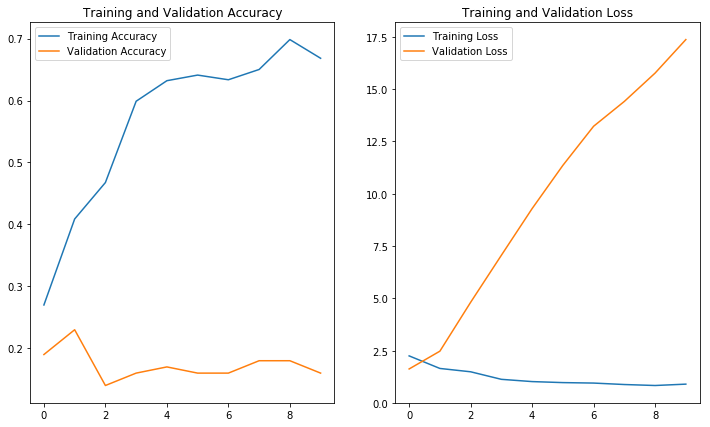

In [45]:
acc = history_4.history['categorical_accuracy']
val_acc = history_4.history['val_categorical_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

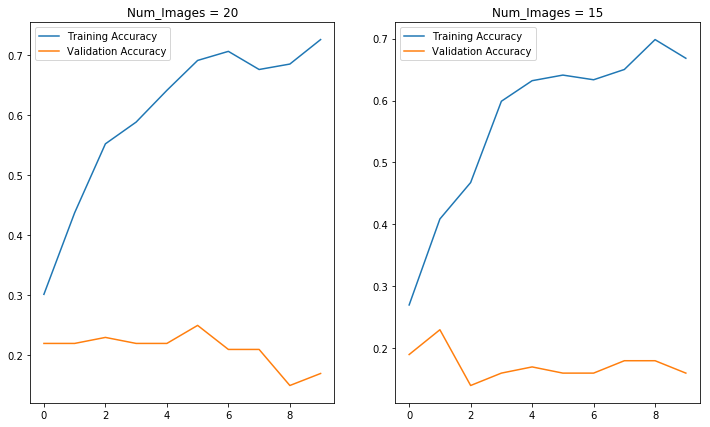

In [46]:
acc_2 = history_2.history['categorical_accuracy']
val_acc_2 = history_2.history['val_categorical_accuracy']

acc_4 = history_4.history['categorical_accuracy']
val_acc_4 = history_4.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Num_Images = 20')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_4, label='Training Accuracy')
plt.plot(epochs_range, val_acc_4, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Num_Images = 15')

plt.show()

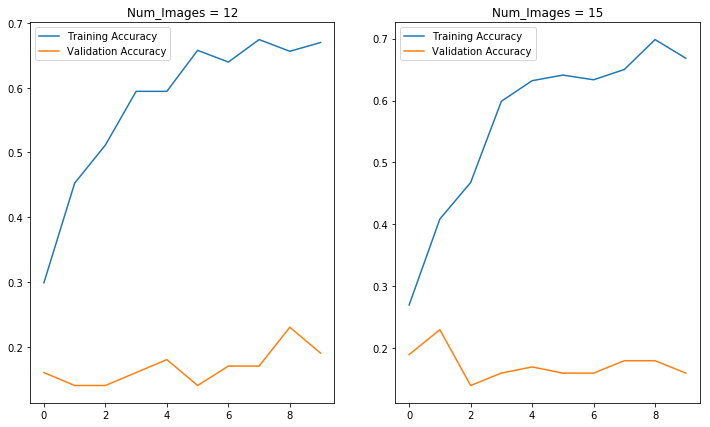

In [47]:
acc_3 = history_3.history['categorical_accuracy']
val_acc_3 = history_3.history['val_categorical_accuracy']

acc_4 = history_4.history['categorical_accuracy']
val_acc_4 = history_4.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_3, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Num_Images = 12')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_4, label='Training Accuracy')
plt.plot(epochs_range, val_acc_4, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Num_Images = 15')

plt.show()

### Observation:
Number of images did not impact the accuracy.We decided to proceed with 12 images per gesture.


## Experiment 6:
Image size= (80,80) <br>
Epochs =10<br>
Batch size= 40<br>
Number of images =12<br>
Cropping of Images = 'False'<br>
Dropouts = "Yes"<br>
Learning Rate = 0.001

In [56]:
image_shape = (80, 80)
num_images = 12

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (80, 80)
Number of images from each folder:  12


In [57]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [58]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 12, 80, 80, 16)    400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 12, 80, 80, 16)    64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 6, 40, 40, 16)     0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 6, 40, 40, 16)     0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 6, 40, 40, 32)     4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 5, 39, 39, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 5, 39, 39, 32)    

In [59]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [60]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [61]:
history_5 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 2.3772 - categorical_accuracy: 0.2504Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-2.37715-0.25038-1.71328-0.16000.h5
17/17 [==============================] - 40s 2s/step - loss: 2.3772 - categorical_accuracy: 0.2504 - val_loss: 1.7133 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.8720 - categorical_accuracy: 0.3710
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.87195-0.37104-1.75396-0.17000.h5
17/17 [==============================] - 40s 2s/step - loss: 1.8720 - categorical_accuracy: 0.3710 - val_loss: 1.7540 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 1.6075 - categorical_accuracy: 0.4163
Epoch 00003: saving model to mod

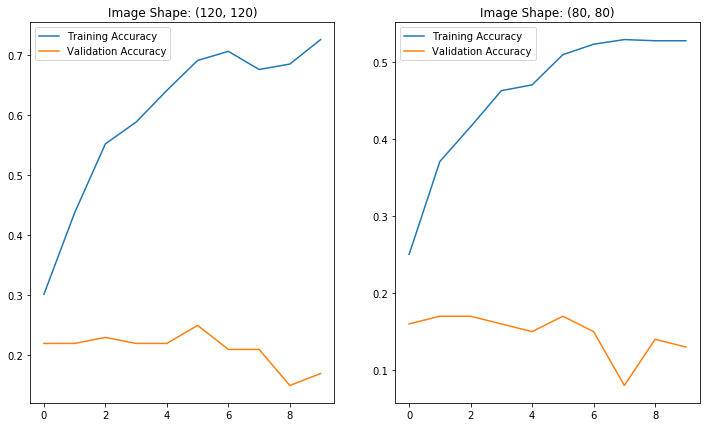

In [63]:
acc_2 = history_2.history['categorical_accuracy']
val_acc_2 = history_2.history['val_categorical_accuracy']

acc_5 = history_5.history['categorical_accuracy']
val_acc_5 = history_5.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Image Shape: (120, 120)')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_5, label='Training Accuracy')
plt.plot(epochs_range, val_acc_5, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Image Shape: (80, 80)')

plt.show()

### Observation
Changing Image size to (80,80) affected the accuracy of the model.

## Experiment 7: 

Image size= (100, 100) <br>
Epochs =10<br>
Batch size= 40<br>
Number of images =20<br>
Cropping of Images = 'False'<br>
Dropouts = "Yes"<br>
Learning Rate = 0.001

In [64]:
image_shape = (100, 100)

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (100, 100)
Number of images from each folder:  12


In [65]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [66]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 12, 100, 100, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 12, 100, 100, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 6, 50, 50, 16)     0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 6, 50, 50, 16)     0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 6, 50, 50, 32)     4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 5, 49, 49, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 5, 49, 49, 32)    

In [67]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [68]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [69]:
history_6 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 2.3744 - categorical_accuracy: 0.2504Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-2.37445-0.25038-2.00361-0.23000.h5
17/17 [==============================] - 44s 3s/step - loss: 2.3744 - categorical_accuracy: 0.2504 - val_loss: 2.0036 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.6403 - categorical_accuracy: 0.3771
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.64035-0.37707-2.46629-0.22000.h5
17/17 [==============================] - 43s 3s/step - loss: 1.6403 - categorical_accuracy: 0.3771 - val_loss: 2.4663 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 1.4150 - categorical_accuracy: 0.4857
Epoch 00003: saving model to mod

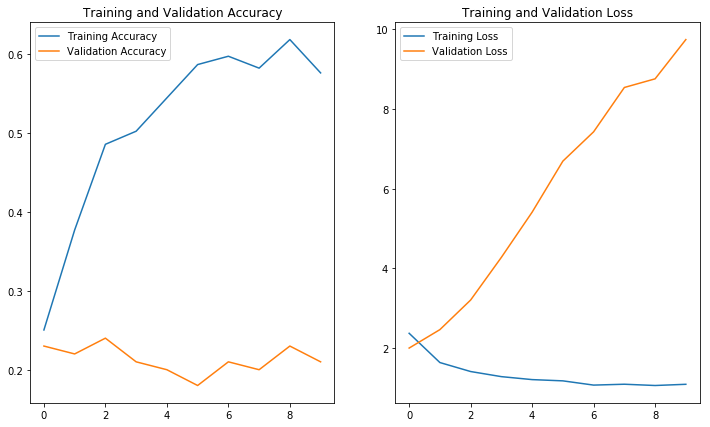

In [70]:
acc = history_6.history['categorical_accuracy']
val_acc = history_6.history['val_categorical_accuracy']

loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

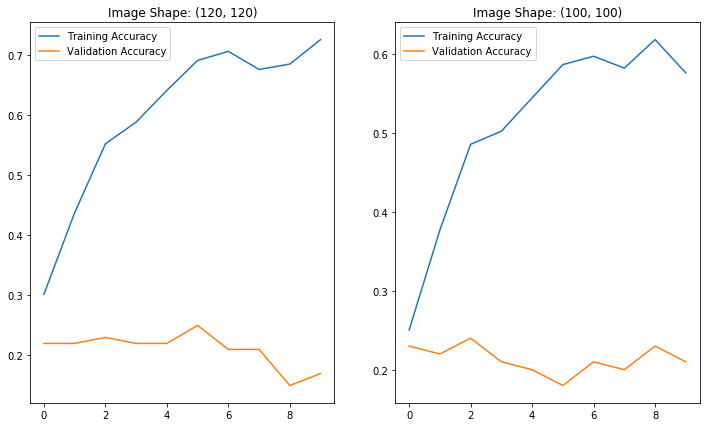

In [71]:
acc_2 = history_2.history['categorical_accuracy']
val_acc_2 = history_2.history['val_categorical_accuracy']

acc_6 = history_6.history['categorical_accuracy']
val_acc_6 = history_6.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Image Shape: (120, 120)')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_6, label='Training Accuracy')
plt.plot(epochs_range, val_acc_6, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Image Shape: (100, 100)')

plt.show()

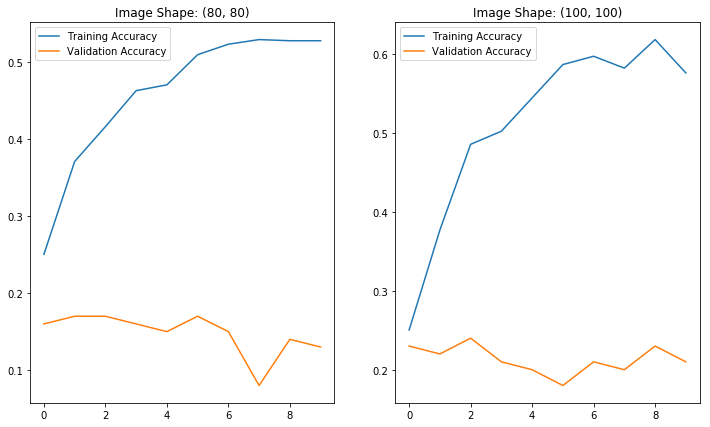

In [72]:
acc_5 = history_5.history['categorical_accuracy']
val_acc_5 = history_5.history['val_categorical_accuracy']

acc_6 = history_6.history['categorical_accuracy']
val_acc_6 = history_6.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_5, label='Training Accuracy')
plt.plot(epochs_range, val_acc_5, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Image Shape: (80, 80)')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_6, label='Training Accuracy')
plt.plot(epochs_range, val_acc_6, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Image Shape: (100, 100)')

plt.show()

### Observation
Changing Image size to (120,120) performs better

## Experiment 8: 

Image size= (120, 120) <br>
Epochs =10<br>
Batch size= 40<br>
Number of images =12<br>
Cropping of Images = 'False'<br>
Dropouts = "Yes"<br>
Learning Rate = 0.01

In [73]:
image_shape = (120, 120)

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (120, 120)
Number of images from each folder:  12


In [74]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [79]:
optimiser = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 12, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 12, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 6, 60, 60, 16)     0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 6, 60, 60, 16)     0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 6, 60, 60, 32)     4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 5, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 5, 59, 59, 32)    

In [80]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [81]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [82]:
history_7 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 1.4812 - categorical_accuracy: 0.4087Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-1.48122-0.40875-14.99851-0.27000.h5
17/17 [==============================] - 46s 3s/step - loss: 1.4812 - categorical_accuracy: 0.4087 - val_loss: 14.9985 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.1090 - categorical_accuracy: 0.5641
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.10903-0.56410-12.14866-0.33000.h5
17/17 [==============================] - 46s 3s/step - loss: 1.1090 - categorical_accuracy: 0.5641 - val_loss: 12.1487 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.9217 - categorical_accuracy: 0.6320
Epoch 00003: saving model to

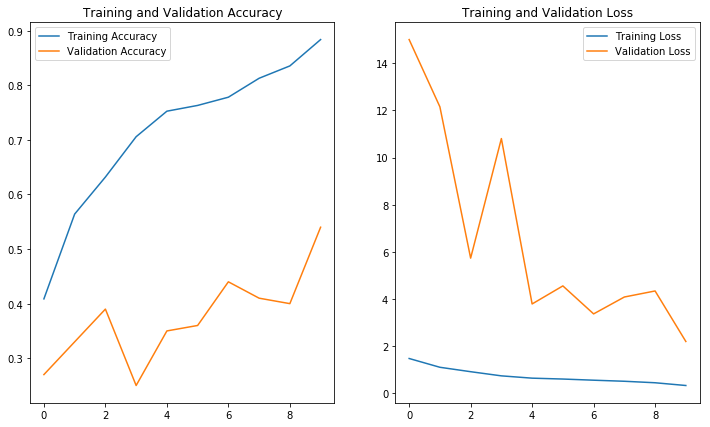

In [83]:
acc = history_7.history['categorical_accuracy']
val_acc = history_7.history['val_categorical_accuracy']

loss = history_7.history['loss']
val_loss = history_7.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

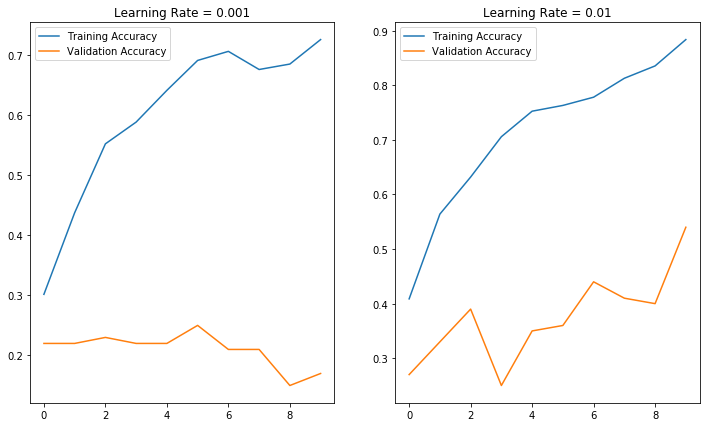

In [85]:
acc_2 = history_2.history['categorical_accuracy']
val_acc_2 = history_2.history['val_categorical_accuracy']

acc_7 = history_7.history['categorical_accuracy']
val_acc_7 = history_7.history['val_categorical_accuracy']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Learning Rate = 0.001')

plt.subplot(1, 2, 2)

plt.plot(epochs_range, acc_7, label='Training Accuracy')
plt.plot(epochs_range, val_acc_7, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Learning Rate = 0.01')

plt.show()

### Observations:
Increasing the learning rate has improved the accuracies of the model. Also, the overfitting degree has lessened now

## Experiment 9
Image size= (120, 120) <br>
Epochs =20<br>
Batch size= 40<br>
Number of images =12<br>
Cropping of Images = 'False'<br>
Dropouts = "Yes"<br>
Learning Rate = 0.01

In [91]:
batch_size = 40
image_shape = (120, 120)
num_images = 12

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (120, 120)
Number of images from each folder:  12


In [92]:
#write your model here
model = Sequential([
    Conv3D(16,
           2,
           padding='same',
           activation='relu',
           input_shape=(num_images, image_shape[0], image_shape[1], 3),
           name='Conv3D_1'),
    BatchNormalization(name="BatchNormalization_1"),
    MaxPooling3D(
        2, data_format='channels_last', name="MaxPooling3D_1"
    ),  # Padding used to handle the input size not being a integer multiple of kernel and stride
    Dropout(0.35),
    Conv3D(32, 2, padding='same', activation='relu', name="Conv3D_2"),
    Conv3D(32, 2, activation='relu', name="Conv3D_3"),
    BatchNormalization(name="BatchNormalization_2"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_2"),
    Dropout(0.35),
    Conv3D(64, 2, padding='same', activation='relu', name="Conv3D_4"),
    BatchNormalization(name="BatchNormalization_3"),
    MaxPooling3D(2, data_format='channels_last', name="MaxPooling3D_3"),
    Dropout(0.35),
    Flatten(name="Flatten_1"),
    Dense(256, activation='relu', name="Dense_1"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(128, activation='relu', name="Dense_2"),
    BatchNormalization(),
    Dropout(0.45),
    Dense(5, activation="softmax")
])

In [93]:
optimiser = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv3D_1 (Conv3D)            (None, 12, 120, 120, 16)  400       
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 12, 120, 120, 16)  64        
_________________________________________________________________
MaxPooling3D_1 (MaxPooling3D (None, 6, 60, 60, 16)     0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 6, 60, 60, 16)     0         
_________________________________________________________________
Conv3D_2 (Conv3D)            (None, 6, 60, 60, 32)     4128      
_________________________________________________________________
Conv3D_3 (Conv3D)            (None, 5, 59, 59, 32)     8224      
_________________________________________________________________
BatchNormalization_2 (BatchN (None, 5, 59, 59, 32)   

In [94]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [95]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [97]:
num_epochs = 20
history_8 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.9132 - categorical_accuracy: 0.3137Source path =  Project_data/val ; batch size = 40

Epoch 00001: saving model to model_2021-07-1307_38_51.238417/model-00001-1.91324-0.31373-17.08951-0.21000.h5
17/17 [==============================] - 46s 3s/step - loss: 1.9132 - categorical_accuracy: 0.3137 - val_loss: 17.0895 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.4594 - categorical_accuracy: 0.4042
Epoch 00002: saving model to model_2021-07-1307_38_51.238417/model-00002-1.45939-0.40422-17.25706-0.19000.h5
17/17 [==============================] - 46s 3s/step - loss: 1.4594 - categorical_accuracy: 0.4042 - val_loss: 17.2571 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.3675 - categorical_accuracy: 0.4585
Epoch 00003: saving model to model_2021-07-1307_38_51.238417/model-00003-1.36752

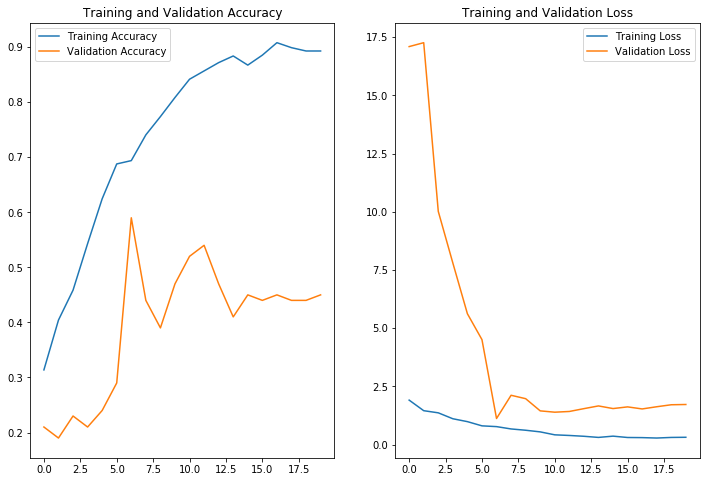

In [98]:
acc = history_8.history['categorical_accuracy']
val_acc = history_8.history['val_categorical_accuracy']

loss = history_8.history['loss']
val_loss = history_8.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.show()

# CNN + RNN - Transfer Learning

Image size= (100, 100) <br>
Epochs =15<br>
Batch size= 40<br>
Number of images =12<br>
Cropping of Images = 'False'<br>
Dropouts = "Yes"<br>
Learning Rate = 0.01

In [99]:
batch_size = 40
image_shape = (120, 120)
num_images = 12

print('Batch Size: ', batch_size)
print('Image Size: ', image_shape)
print('Number of images from each folder: ', num_images)

Batch Size:  40
Image Size:  (120, 120)
Number of images from each folder:  12


In [100]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

#write your model here
# Transfer Learning

base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(image_shape[0], image_shape[1], 3))
x = base_model.output
x = Flatten()(x)
# x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False

# RNN
model = Sequential()
model.add(
    TimeDistributed(conv_model,
                    input_shape=((num_images, image_shape[0], image_shape[1],
                                  3))))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 64)            15009664  
_________________________________________________________________
gru (GRU)                    (None, 12, 32)            9408      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_57 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 45        
Total params: 15,021,653
Trainable params: 306,965
Non

In [101]:
train_generator = generator(train_path,
                            train_doc,
                            batch_size,
                            image_shape,
                            num_images=num_images)
val_generator = generator(val_path,
                          val_doc,
                          batch_size,
                          image_shape,
                          num_images=num_images)

In [102]:
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

In [103]:
num_epochs = 5

In [104]:
history_9 = model.fit(train_generator,
                      steps_per_epoch=steps_per_epoch,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks_list,
                      validation_data=val_generator,
                      validation_steps=validation_steps,
                      class_weight=None,
                      workers=1,
                      initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/5
17/17 [==============================] - 52s 3s/step - loss: 1.5944 - categorical_accuracy: 0.2398 - val_loss: 1.5009 - val_categorical_accuracy: 0.3600
Epoch 2/5
17/17 [==============================] - 47s 3s/step - loss: 1.4480 - categorical_accuracy: 0.3816 - val_loss: 1.3761 - val_categorical_accuracy: 0.4200
Epoch 3/5
17/17 [==============================] - 44s 3s/step - loss: 1.3232 - categorical_accuracy: 0.4947 - val_loss: 1.2411 - val_categorical_accuracy: 0.5800
Epoch 4/5
17/17 [==============================] - 46s 3s/step - loss: 1.1612 - categorical_accuracy: 0.5822 - val_loss: 1.1274 - val_categorical_accuracy: 0.6700
Epoch 5/5
17/17 [==============================] - 46s 3s/step - loss: 1.0000 - categorical_accuracy: 0.6833 - val_loss: 0.9961 - val_categorical_accuracy: 0.6500


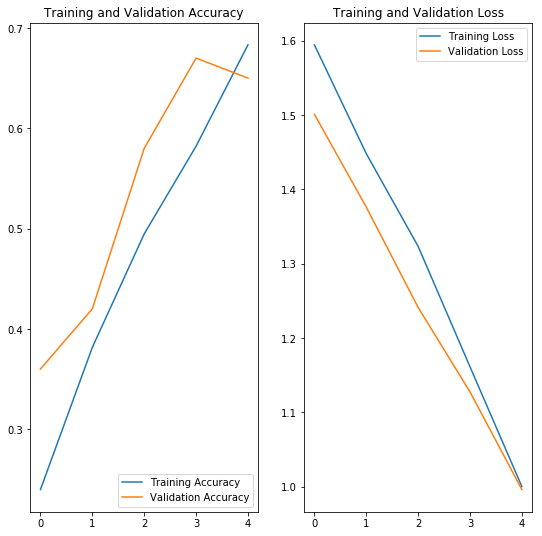

In [105]:
acc = history_9.history['categorical_accuracy']
val_acc = history_9.history['val_categorical_accuracy']

loss = history_9.history['loss']
val_loss = history_9.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
num_epochs = 10  # Totally ran for 15 epochs in order to avoid overfitting

In [108]:
history_10 = model.fit(train_generator,
                       steps_per_epoch=steps_per_epoch,
                       epochs=num_epochs,
                       verbose=1,
                       callbacks=callbacks_list,
                       validation_data=val_generator,
                       validation_steps=validation_steps,
                       class_weight=None,
                       workers=1,
                       initial_epoch=0)

Epoch 1/10
17/17 [==============================] - 45s 3s/step - loss: 0.8647 - categorical_accuracy: 0.7436 - val_loss: 0.9648 - val_categorical_accuracy: 0.7100
Epoch 2/10
17/17 [==============================] - 46s 3s/step - loss: 0.7708 - categorical_accuracy: 0.7888 - val_loss: 0.8254 - val_categorical_accuracy: 0.7500
Epoch 3/10
17/17 [==============================] - 46s 3s/step - loss: 0.6220 - categorical_accuracy: 0.8703 - val_loss: 0.6864 - val_categorical_accuracy: 0.8000
Epoch 4/10
17/17 [==============================] - 45s 3s/step - loss: 0.5391 - categorical_accuracy: 0.8718 - val_loss: 0.7215 - val_categorical_accuracy: 0.7700
Epoch 5/10
17/17 [==============================] - 46s 3s/step - loss: 0.4841 - categorical_accuracy: 0.8914 - val_loss: 0.6907 - val_categorical_accuracy: 0.7600
Epoch 6/10
17/17 [==============================] - 48s 3s/step - loss: 0.4008 - categorical_accuracy: 0.9261 - val_loss: 0.6736 - val_categorical_accuracy: 0.8000
Epoch 7/10
17/17

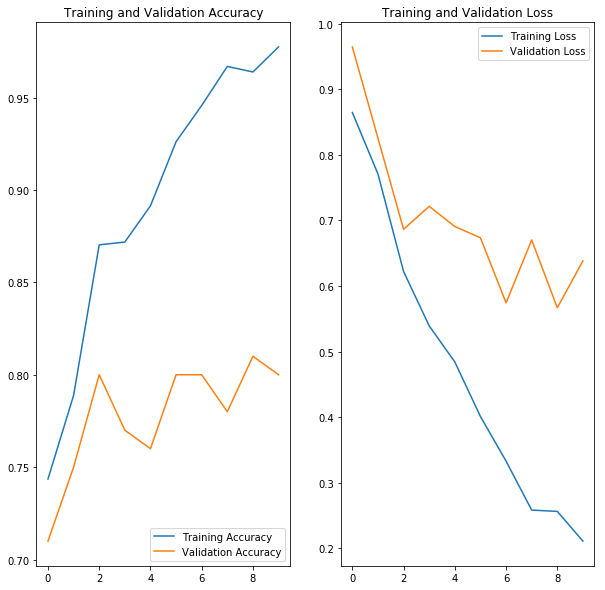

In [109]:
acc = history_10.history['categorical_accuracy']
val_acc = history_10.history['val_categorical_accuracy']

loss = history_10.history['loss']
val_loss = history_10.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion

Though parameters are much more in (CNN + RNN) architecture it's more stable and has the highest accuracies in both train and validation data